In [2]:
"""
This is a re-implementation of the material in exercise 1 of Andrew Ng's Coursera Machine Learning class, 
plus some additional exploration. Ng's class uses Octave exclusively, this implementation uses Numpy for 
all vectorized operations. 
"""
%matplotlib inline
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


data = np.loadtxt('ex1data1.txt', delimiter=',')
X = np.matrix(data[:, 0]).T
y = np.matrix(data[:, 1]).T

IndexError: index 2 is out of bounds for axis 1 with size 2

# The dataset:

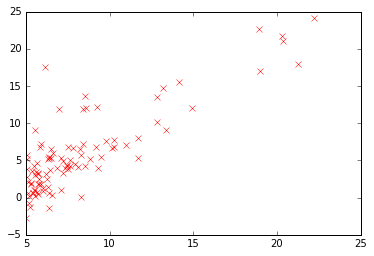

In [91]:
plt.plot(X, y, 'rx')

# Performing gradient descent to find the optimal value of theta. 

We're going to use a linear hypothesis with two features: 

$$h_{\theta}(x) = \theta x$$
We could also use the normal equation:
$$ (X^{T}X)^{-1}X^{T}y $$

to find the correct value for theta without performing gradient descent,
but that is less educational.

In [92]:
m, features = np.shape(X)
features += 1
X = np.concatenate([np.ones((m, 1)), X], axis=1)
initial_theta = np.zeros((features, 1))
GradientParams = namedtuple('GradientParams', 'theta costs iterations')


def cost(theta, X, y):
    """ The squared error of the hypothesis. """
    error = (X.dot(theta) - y)
    return error.T.dot(error) / (2 * m)


def grad(alpha, theta, m, X, y): 
    """ The gradient of Theta. """
    error = (X.dot(theta) - y)
    theta -= (alpha/m) * error.T.dot(X).T
    return theta


def gradient_descent(theta, X, y, iterations=1000, alpha=0.01):
    costs = []
    for step in range(iterations):
        if step % 10 == 0:
            costs.append(cost(theta, X, y)[0, 0])
        theta = grad(alpha, theta, m, X, y)
    return GradientParams(theta, costs, iterations)

gradient_data = gradient_descent(initial_theta, X, y)
theta = gradient_data.theta
costs = gradient_data.costs

# The cost curve as we do gradient descent:

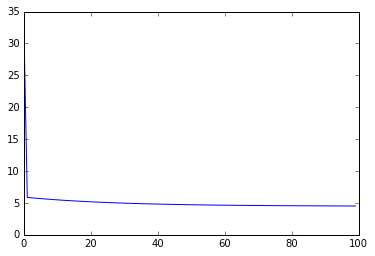

In [93]:
plt.plot(costs)

# We now have a linear model of the data:

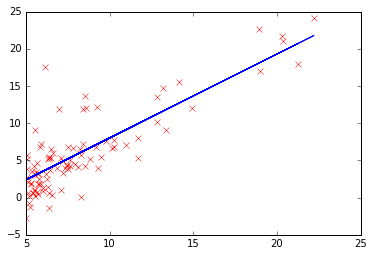

In [94]:
model = lambda x: x.dot(theta)
# We omit the first column because those are the 1s that we appended onto X:
plt.plot(X[:, 1], y, 'rx')
plt.plot(X[:, 1], model(X))

# The square-error surface of our linear model:

In [95]:
GridParams = namedtuple('GridParams', 't0_values t1_values j_values')


def error_surface(X, y, grid_size=100, t0_min=-40, to_max=40, t1_min=-8.5, t1_max=11.5):
    """
    Does a grid-scan to compute the error surface defined by X and y.
    This only works for two-featured data sets.
        
    Returns a GridParams namedtuple.     
    """
    theta = np.zeros((2, 1))
    theta0_vals = np.zeros((grid_size, grid_size))
    theta1_vals = np.zeros((grid_size, grid_size))
    J_vals = np.zeros((grid_size, grid_size))
    zero_steps = np.linspace(t0_min, to_max, grid_size)
    one_steps = np.linspace(t1_min, t1_max, grid_size)

    for zero_index, theta0 in enumerate(zero_steps):
        for one_index, theta1 in enumerate(one_steps):
            theta[0, 0] = theta0
            theta[1, 0] = theta1
            theta0_vals[zero_index, one_index] = theta0
            theta1_vals[zero_index, one_index] = theta1
            J_vals[zero_index, one_index] = cost(theta, X, y)
    return GridParams(theta0_vals, theta1_vals, J_vals)

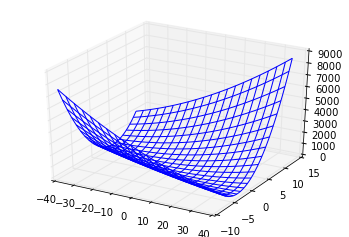

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
errors = error_surface(X, y)
ax.plot_wireframe(errors.t0_values, errors.t1_values, errors.j_values, rstride=5, cstride=5)
plt.show()

# It seems like ipython can only either display inline figures or 
# interactive figure in separate windows, but not both in a notebook. :(

# IsoErrors
(This section is a personal exploration, not included in the Ng course.)

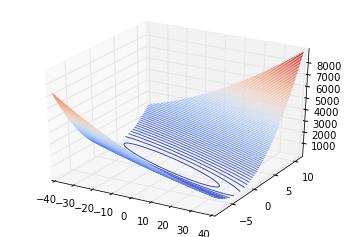

In [97]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
number_contours = 100
cset = ax.contour(errors.t0_values, errors.t1_values, errors.j_values, number_contours, cmap=cm.coolwarm)
ax.clabel(cset, fontsize=9, inline=1)
plt.show()

# Note: This graph is particularly cool in interactive mode, comment out the `inline` directive at the head of 
# the file and restart the kernal to see. 

Each curve on the above plot is an 'isoerror' curve -- it represents theta values which give the same squared error.
We can extract those curves from the contour set. Each point on the curves represent values for the theta parameter 
which we can then plot to see the space of models with the same squared error.

It tooks quite a while to figure out the datastructure of the cset, as it's pyplot internals 
that are not fully documented. This SO question plus some persistent guessing eventually allowed 
me to figure it out: https://stackoverflow.com/questions/19418901/get-coordinates-from-the-contour-in-matplotlib


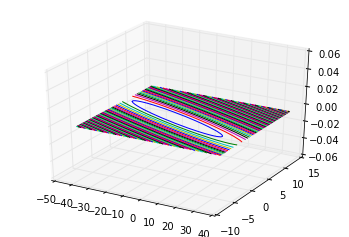

In [98]:
# Proof of concept to show that we can extract the coordinate date from the data-structure:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for segment in cset.allsegs:
    xs0 = segment[0][:, 0]
    ys0 = segment[0][:, 1]
    ax.plot(xs0, ys0, 0)
    
    # segment[0] represents one set of contours, segment[1] the other. These are, roughly, the left and right side
    # of the graph. Notably, the sets are not the same size.
    try:
        xs1 = segment[1][:, 0]
        ys1 = segment[1][:, 1]
        ax.plot(xs1, ys1, 0)
    except IndexError:
        pass

# IsoError models

Varying the value of `segment_index` will plot iso-error models from different curves in the squared error contour set.

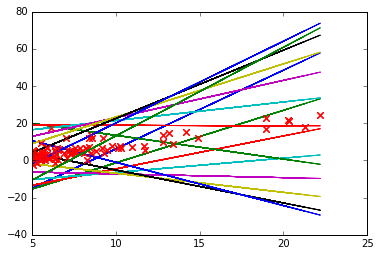

In [99]:
segment_index = 0
segment = cset.allsegs[segment_index][0]
for index in range(0, len(segment), 15):
    theta = segment[index].reshape(2, 1)
    error_model = lambda x, theta: x.dot(theta)
    plt.plot(X[:, 1], y, 'rx')
    plt.plot(X[:, 1], error_model(X, theta))

![Ruled hyperbolid surface, image from Wikipedia.](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Ruled_hyperboloid.jpg/330px-Ruled_hyperboloid.jpg)
Some of the configurations of the state space look like a projection of a ruled hyperboliod! It's being generated by a parabolic surface, so this shouldn't have been surprising, but it still was.

-----------------

-----------------

# Multivariate linear regression
"The file `ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the hous"


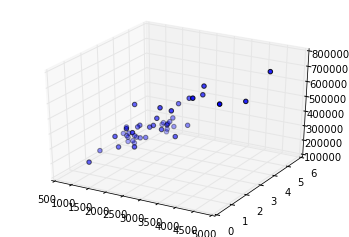

In [100]:
data = np.loadtxt('ex1data2.txt', delimiter=',')
X = np.matrix(data[:, 0:2])
y = np.matrix(data[:, 2]).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y.A)

The absolute values of the features are very different, therefore we perform feature scaling to 
make gradient descent more efficient. Here we plot the speed of convergence of gradient descent before and after feature scaling and normalization:

## Before feature scaling & normalization

Cost after 1000 iterations: 2397824813.93


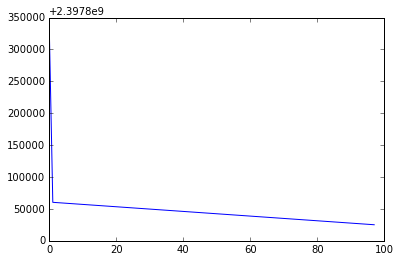

In [101]:
m, features = np.shape(X)
features += 1
X1 = np.concatenate([np.ones((m, 1)), X], axis=1)
initial_theta = np.zeros((features, 1))
# Note the very small learning rate. Larger learning rates cause the gradient descent algorithm to diverge. 
gradient_data = gradient_descent(initial_theta, X1, y, alpha = 0.0000001)
plt.plot(gradient_data.costs[1:-1])
print 'Cost after %s iterations: %s' % (gradient_data.iterations, gradient_data.costs[-1])

Note: We're excluding the first cost data point to more clearly show that the gradient descent still has not converged. 

Clearly this is... poor performance. 

Now we scale and normalize the data set:

## After feature scaling & normalization

Cost after 1000 iterations: 2043280050.6


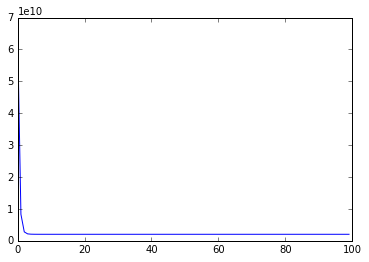

In [102]:
means = X.mean(0)
X1_scaled = X - means
std = X1_scaled.std(0)
X1_scaled /= std

m, features = np.shape(X1_scaled)
X_final = np.concatenate([np.ones((m, 1)), X1_scaled], axis=1)
features += 1
initial_theta = np.zeros((features, 1))
gradient_data = gradient_descent(initial_theta, X_final, y, alpha = 0.1)
plt.plot(gradient_data.costs)
print 'Cost after %s iterations: %s' % (gradient_data.iterations, gradient_data.costs[-1])


Here, gradient descent clearly has converged, and even larger values of alpha could be used. 